# Candidate Generation and LGBM

## 1. Setup and imports

* pip install pyarrow (for loading parquets)
* pip install lightgbm (May require installation of other packages: https://github.com/microsoft/LightGBM/tree/master/python-package)

In [1]:
import pandas as pd
import matplotlib as plt
import numpy as np

from average_precision import apk, mapk

In [2]:
# Helper functions for improving memory
# https://www.kaggle.com/c/h-and-m-personalized-fashion-recommendations/discussion/308635
def hex_id_to_int(str):
    return int(str[-16:], 16)

def customer_hex_id_to_int(series):
    return series.str[-16:].apply(hex_id_to_int)

All categorical columns in transactions, customers, and articles have been converted into a numerical code within the saved parquet. All NaN values were replaced with -1. LGBM models perform best when the categorical columns are encoded as integers. 

## 2. Load data

In [3]:
transactions = pd.read_parquet('data/transactions_train_sample_gt15transactions.parquet')
customers = pd.read_parquet('data/customers_sample_gt15transactions.parquet')
articles = pd.read_parquet('data/articles_sample_gt15transactions.parquet')

### Transactions data

In [4]:
transactions.head()

,t_dat,customer_id,article_id,price,sales_channel_id,week
0,2018-09-20,1728846800780188,519773001,0.028458,2,0
1,2018-09-20,1728846800780188,578472001,0.032525,2,0
2,2018-09-20,2076973761519164,661795002,0.167797,2,0
3,2018-09-20,2076973761519164,684080003,0.101678,2,0
4,2018-09-20,2918879973994241,662980001,0.033881,1,0


In [5]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27113639 entries, 0 to 27113638
Data columns (total 6 columns):
 #   Column            Dtype         
---  ------            -----         
 0   t_dat             datetime64[ns]
 1   customer_id       uint64        
 2   article_id        int32         
 3   price             float32       
 4   sales_channel_id  int8          
 5   week              int8          
dtypes: datetime64[ns](1), float32(1), int32(1), int8(2), uint64(1)
memory usage: 672.3 MB


Number of transactions made per week

<AxesSubplot:title={'center':'Number of Transactions per Week'}>

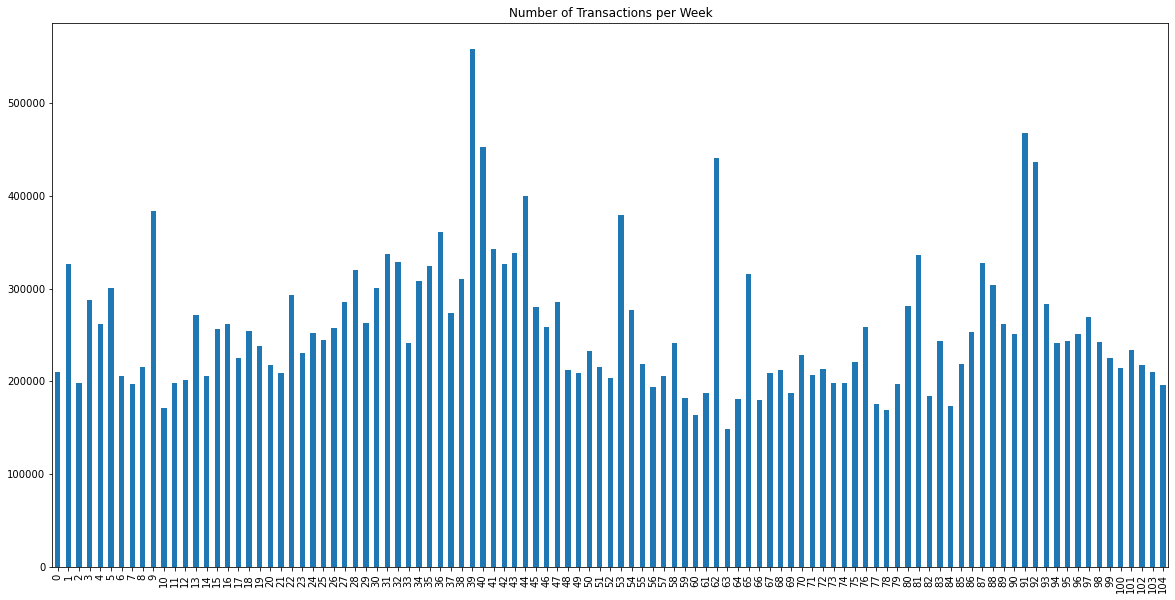

In [6]:
transactions['week']\
    .value_counts()\
    .sort_index()\
    .plot(figsize = (20, 10), kind='bar', title = 'Number of Transactions per Week')

### Customers data

In [7]:
customers.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,6883939031699146327,-1,-1,0,0,49,6305
1,11246327431398957306,-1,-1,0,0,25,33726
2,18439897732908966680,-1,-1,0,0,24,3247
3,10112112306570742978,1,1,0,1,32,80340
4,14916087826260610165,1,1,0,1,56,284766


In [8]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 513076 entries, 0 to 513075
Data columns (total 7 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   customer_id             513076 non-null  uint64
 1   FN                      513076 non-null  int8  
 2   Active                  513076 non-null  int8  
 3   club_member_status      513076 non-null  int8  
 4   fashion_news_frequency  513076 non-null  int8  
 5   age                     513076 non-null  int8  
 6   postal_code             513076 non-null  int32 
dtypes: int32(1), int8(5), uint64(1)
memory usage: 8.3 MB


### Articles data

In [9]:
articles.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,12855,253,9,0,1010016,0,9,0,...,10,0,0,1,0,16,30,1002,2,8834
1,108775044,108775,12855,253,9,0,1010016,0,10,2,...,10,0,0,1,0,16,30,1002,2,8834
2,108775051,108775,44846,253,9,0,1010017,3,11,11,...,10,0,0,1,0,16,30,1002,2,8834
3,110065001,110065,8159,306,13,4,1010016,0,9,0,...,131,7,7,1,0,61,5,1017,4,8243
4,110065002,110065,8159,306,13,4,1010016,0,10,2,...,131,7,7,1,0,61,5,1017,4,8243


In [10]:
articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103570 entries, 0 to 103569
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype
---  ------                        --------------   -----
 0   article_id                    103570 non-null  int32
 1   product_code                  103570 non-null  int32
 2   prod_name                     103570 non-null  int32
 3   product_type_no               103570 non-null  int32
 4   product_type_name             103570 non-null  int16
 5   product_group_name            103570 non-null  int8 
 6   graphical_appearance_no       103570 non-null  int32
 7   graphical_appearance_name     103570 non-null  int8 
 8   colour_group_code             103570 non-null  int32
 9   colour_group_name             103570 non-null  int8 
 10  perceived_colour_value_id     103570 non-null  int32
 11  perceived_colour_value_name   103570 non-null  int8 
 12  perceived_colour_master_id    103570 non-null  int32
 13  perceived_colo

## 5. Train, validation, test split

"Leave One Last Item" train, validation, test split from https://arxiv.org/pdf/2007.13237.pdf

TODO - Make sure Marina's collaborative filtering only uses the data from the train transactions

In [11]:
val_week = transactions["week"].max() # Last week in the training set

# train/ val transactions sets
train_transactions = transactions[transactions["week"] != val_week] 
val_transactions = transactions[transactions["week"] == val_week].reset_index(drop = True)

In [12]:
train_transactions.shape

(26917851, 6)

In [13]:
val_transactions.shape

(195788, 6)

## 6. Candidate Generation

df with each customers last transaction. This will be the base df that we will merge all generated candidates into

In [14]:
# The transaction of each customers last transaction
unique_customers = transactions \
    .groupby(['customer_id']) \
    .tail(1) \
    .drop(columns=['article_id', 'price']) \
    .copy()
unique_customers['week'].value_counts()[104]

51563

### 6.1 Collaborative Filtering Results

Read collaborative filtering csv results

In [15]:
customers_rec_articles = pd.read_csv("costumers_rec_articles_fixed.csv")
customers_rec_articles.head()

,costumer_id,recom_articles
0,31585195778922258,"[704128001, 825600002, 736672003, 761248002, 3..."
1,115839770399079596,"[938624001, 644288001, 490176002, 399136004, 4..."
2,272085172814114531,"[706016001, 674400001, 355072003, 775328008, 8..."
3,498133084769137863,"[729808002, 727616003, 879248004, 853792005, 6..."
4,510252261938392406,"[818320001, 637515010, 804496002, 762096004, 8..."


In [16]:
customers_rec_articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1105 entries, 0 to 1104
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   costumer_id     1105 non-null   uint64
 1   recom_articles  1105 non-null   object
dtypes: object(1), uint64(1)
memory usage: 17.4+ KB


Rename and reorder columns

In [17]:
customers_rec_articles['customer_id'] = customers_rec_articles['costumer_id']
customers_rec_articles = customers_rec_articles.drop('costumer_id', axis = 1) # Rename column to correct costumer to customer
customers_rec_articles = customers_rec_articles[['customer_id', 'recom_articles']] # reorder columns
customers_rec_articles.head()

,customer_id,recom_articles
0,31585195778922258,"[704128001, 825600002, 736672003, 761248002, 3..."
1,115839770399079596,"[938624001, 644288001, 490176002, 399136004, 4..."
2,272085172814114531,"[706016001, 674400001, 355072003, 775328008, 8..."
3,498133084769137863,"[729808002, 727616003, 879248004, 853792005, 6..."
4,510252261938392406,"[818320001, 637515010, 804496002, 762096004, 8..."


Merge the recommended articles with the transaction data to generate negative samples

In [18]:
collab_candidates = pd.merge(
    unique_customers, # base df to merge all results into
    customers_rec_articles, # collaborative filtering results
    on='customer_id'
)

collab_candidates.head()

,t_dat,customer_id,sales_channel_id,week,recom_articles
0,2019-10-16,17685829231157282976,2,56,"[878720001, 836480003, 708352004, 408875020, 6..."
1,2019-10-16,17685829231157282976,2,56,[]
2,2019-10-16,17685829231157282976,2,56,[]
3,2019-10-16,17685829231157282976,2,56,"[878720001, 836480003, 708352004, 408875020, 6..."
4,2019-10-16,17685829231157282976,2,56,"[878720001, 836480003, 708352004, 408875020, 6..."


recom_articles column is a list as a *string* type. We could resolve this by saving the recommendations as a pickle file instead of a csv. <br>
Alternatively, we can use json (as shown below) to convert the data into a list (of list type) as desired

In [19]:
import json
collab_candidates['recom_articles'] = collab_candidates['recom_articles'].apply(lambda x: json.loads(x))

Create one row per customer_id, article_id combination

In [20]:
collab_candidates = collab_candidates.explode('recom_articles').reset_index(drop=True)
collab_candidates['article_id'] = collab_candidates['recom_articles']
collab_candidates = collab_candidates.drop('recom_articles', axis = 1)
collab_candidates.head()

,t_dat,customer_id,sales_channel_id,week,article_id
0,2019-10-16,17685829231157282976,2,56,878720001
1,2019-10-16,17685829231157282976,2,56,836480003
2,2019-10-16,17685829231157282976,2,56,708352004
3,2019-10-16,17685829231157282976,2,56,408875020
4,2019-10-16,17685829231157282976,2,56,628927001


In [21]:
collab_candidates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50479 entries, 0 to 50478
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   t_dat             50479 non-null  datetime64[ns]
 1   customer_id       50479 non-null  uint64        
 2   sales_channel_id  50479 non-null  int8          
 3   week              50479 non-null  int8          
 4   article_id        50025 non-null  object        
dtypes: datetime64[ns](1), int8(2), object(1), uint64(1)
memory usage: 1.3+ MB


In [22]:
collab_candidates = collab_candidates.dropna()
collab_candidates.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50025 entries, 0 to 50478
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   t_dat             50025 non-null  datetime64[ns]
 1   customer_id       50025 non-null  uint64        
 2   sales_channel_id  50025 non-null  int8          
 3   week              50025 non-null  int8          
 4   article_id        50025 non-null  object        
dtypes: datetime64[ns](1), int8(2), object(1), uint64(1)
memory usage: 1.6+ MB


In [23]:
def article_id_str_to_int(series):
    return series.astype('int32')

collab_candidates['article_id'] = article_id_str_to_int(collab_candidates['article_id'])
collab_candidates.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50025 entries, 0 to 50478
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   t_dat             50025 non-null  datetime64[ns]
 1   customer_id       50025 non-null  uint64        
 2   sales_channel_id  50025 non-null  int8          
 3   week              50025 non-null  int8          
 4   article_id        50025 non-null  int32         
dtypes: datetime64[ns](1), int32(1), int8(2), uint64(1)
memory usage: 1.4 MB


TODO? Approach 1: Identify items that customers last purchased

TODO - Approach 2: Bestsellers/ Popular candidates - identify the top 12 bestselling articles per week

## 3. Combining transactions and candidates / negative examples

Label all transactions that actually occurred as 1 (positive samples)

Comment from Pawel in Kaggle discussion here: https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/discussion/307288
In my setting I propose to convert the problem to a table where you have a list of item candidates and you mark the sales as either 0 or 1 depending whether the item was sold in the <b>next</b> week. 

Imagine you want to create negative samples as a list of 1000 most popular items in the last week. Some of those items will be bought by the customers. So the table you need to create is:
customer_id
label = whether it was bought or not
article_id from the list of 1000 most popular items
I'm not saying this is the best approach here but it is more or less what I'm doing. This is a technique where you create a set of explicit negative items. There are also techniques for implicit recommendations but all of them assume some sort of a strategy to generate negative samples.

Positive samples, all previously purchased transactions

In [24]:
transactions["purchased"] = 1 
transactions.shape

(27113639, 7)

Combine positive and negative samples

In [25]:
data = pd.concat([transactions, collab_candidates])
data.purchased.fillna(0, inplace=True) # Label all candidate generated transactions as 0

In [26]:
data.head()

,t_dat,customer_id,article_id,price,sales_channel_id,week,purchased
0,2018-09-20,1728846800780188,519773001,0.028458,2,0,1.0
1,2018-09-20,1728846800780188,578472001,0.032525,2,0,1.0
2,2018-09-20,2076973761519164,661795002,0.167797,2,0,1.0
3,2018-09-20,2076973761519164,684080003,0.101678,2,0,1.0
4,2018-09-20,2918879973994241,662980001,0.033881,1,0,1.0


TODO - logic here with how lgbm works. It drops duplicates. Retains the transactions (positive labels). If duplicated, will drop the duplicates in the negative samples


In [27]:
# Drops duplicates. Retains the transactions (positive labels). If duplicated, will drop the duplicates in the negative samples
data.drop_duplicates(['customer_id', 'article_id', 'week'], inplace=True) 
data.head()

,t_dat,customer_id,article_id,price,sales_channel_id,week,purchased
0,2018-09-20,1728846800780188,519773001,0.028458,2,0,1.0
1,2018-09-20,1728846800780188,578472001,0.032525,2,0,1.0
2,2018-09-20,2076973761519164,661795002,0.167797,2,0,1.0
3,2018-09-20,2076973761519164,684080003,0.101678,2,0,1.0
4,2018-09-20,2918879973994241,662980001,0.033881,1,0,1.0


TODO - add bestseller information see ranking_example.ipynb

Create a joined dataset with transaction, article, and customer information + target values (0/ 1)

In [28]:
data = pd.merge(data, articles, on='article_id', how='left')
data = pd.merge(data, customers, on='customer_id', how='left')

In [29]:
data.sort_values(['week', 'customer_id'], inplace=True)
data.reset_index(drop=True, inplace=True)

In [30]:
data.head()

,t_dat,customer_id,article_id,price,sales_channel_id,week,purchased,product_code,prod_name,product_type_no,...,section_name,garment_group_no,garment_group_name,detail_desc,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,2018-09-21,77117344919861,666006006,0.118627,2,0,1.0,666006,6145,262,...,40,1007,9,5675,-1,-1,0,0,46,22398
1,2018-09-21,77117344919861,662773001,0.084729,2,0,1.0,662773,8356,262,...,40,1007,9,3040,-1,-1,0,0,46,22398
2,2018-09-23,200292573348128,685687002,0.016932,2,0,1.0,685687,4563,252,...,0,1023,19,6161,1,1,0,1,25,63947
3,2018-09-23,200292573348128,612481008,0.016932,2,0,1.0,612481,31204,274,...,0,1025,16,2856,1,1,0,1,25,63947
4,2018-09-23,200292573348128,625939025,0.008458,2,0,1.0,625939,323,255,...,27,1002,2,461,1,1,0,1,25,63947


## 4. Train/ Test data

Train data is currently all transactions from weeks 0-103. The target labels are also obtained from transactions from weeks 0-103 (confirm this is correct or whether we should be predicting the next week, ie wk104)

In [31]:
test_week = val_week

In [32]:
train = data[data.week != test_week]
train.head()

,t_dat,customer_id,article_id,price,sales_channel_id,week,purchased,product_code,prod_name,product_type_no,...,section_name,garment_group_no,garment_group_name,detail_desc,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,2018-09-21,77117344919861,666006006,0.118627,2,0,1.0,666006,6145,262,...,40,1007,9,5675,-1,-1,0,0,46,22398
1,2018-09-21,77117344919861,662773001,0.084729,2,0,1.0,662773,8356,262,...,40,1007,9,3040,-1,-1,0,0,46,22398
2,2018-09-23,200292573348128,685687002,0.016932,2,0,1.0,685687,4563,252,...,0,1023,19,6161,1,1,0,1,25,63947
3,2018-09-23,200292573348128,612481008,0.016932,2,0,1.0,612481,31204,274,...,0,1025,16,2856,1,1,0,1,25,63947
4,2018-09-23,200292573348128,625939025,0.008458,2,0,1.0,625939,323,255,...,27,1002,2,461,1,1,0,1,25,63947


In [33]:
test = data[data.week==test_week].drop_duplicates(['customer_id', 'article_id', 'sales_channel_id']).copy()
test.head()

,t_dat,customer_id,article_id,price,sales_channel_id,week,purchased,product_code,prod_name,product_type_no,...,section_name,garment_group_no,garment_group_name,detail_desc,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
23785723,2020-09-19,1827730561464445,918603001,0.047932,1,104,1.0,918603,26329,252,...,0,1003,3,28672,-1,-1,0,0,30,305856
23785724,2020-09-19,1827730561464445,921380001,0.063898,1,104,1.0,921380,25098,264,...,0,1008,20,28745,-1,-1,0,0,30,305856
23785725,2020-09-17,2639747769247776,819547001,0.027102,1,104,1.0,819547,15053,252,...,0,1003,3,14819,1,1,0,1,24,55211
23785726,2020-09-22,3204013276717965,908728002,0.067000,2,104,1.0,908728,738,265,...,0,1013,8,5495,-1,-1,0,0,25,65115
23785727,2020-09-22,3204013276717965,929001001,0.058627,2,104,1.0,929001,25258,265,...,0,1013,8,27672,-1,-1,0,0,25,65115


In [34]:
# Not yet sure what these are
train_baskets = train.groupby(['week', 'customer_id'])['article_id'].count().values
train_baskets

array([ 2, 10,  2, ...,  2,  1,  5])

Only use a subset of columns specified here as input into the LGBM model

In [35]:
columns_to_use = ['article_id', 'product_type_no', 'graphical_appearance_no', 'colour_group_code', 'perceived_colour_value_id',
'perceived_colour_master_id', 'department_no', 'index_code',
'index_group_no', 'section_no', 'garment_group_no', 'FN', 'Active',
'club_member_status', 'fashion_news_frequency', 'age', 'postal_code'] #, 'bestseller_rank']

### Model input

In [36]:
train_X = train[columns_to_use]
train_y = train['purchased']

test_X = test[columns_to_use]

In [37]:
train_X.head()

,article_id,product_type_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,666006006,262,1010016,12,1,11,1201,0,1,19,1007,-1,-1,0,0,46,22398
1,662773001,262,1010016,9,4,5,1201,0,1,19,1007,-1,-1,0,0,46,22398
2,685687002,252,1010010,7,1,12,3090,0,1,15,1023,1,1,0,1,25,63947
3,612481008,274,1010023,42,5,18,1723,0,1,15,1025,1,1,0,1,25,63947
4,625939025,255,1010017,92,7,19,1643,1,2,51,1002,1,1,0,1,25,63947


In [38]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23785723 entries, 0 to 23785722
Data columns (total 17 columns):
 #   Column                      Dtype
---  ------                      -----
 0   article_id                  int32
 1   product_type_no             int32
 2   graphical_appearance_no     int32
 3   colour_group_code           int32
 4   perceived_colour_value_id   int32
 5   perceived_colour_master_id  int32
 6   department_no               int32
 7   index_code                  int8 
 8   index_group_no              int32
 9   section_no                  int32
 10  garment_group_no            int32
 11  FN                          int8 
 12  Active                      int8 
 13  club_member_status          int8 
 14  fashion_news_frequency      int8 
 15  age                         int8 
 16  postal_code                 int32
dtypes: int32(11), int8(6)
memory usage: 1.3 GB


## 5. Model training

In [39]:
from lightgbm.sklearn import LGBMRanker

In [40]:
ranker = LGBMRanker(
    objective="lambdarank",
    metric="ndcg",
    boosting_type="dart",
    n_estimators=1,
    importance_type='gain',
    verbose=10
)

In [41]:
# not sure what group = train_baskets is for
ranker = ranker.fit(
    train_X,
    train_y,
    group=train_baskets,
)

[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.115381
[LightGBM] [Debug] init for col-wise cost 0.000051 seconds, init for row-wise cost 0.744084 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.264842 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 1106
[LightGBM] [Info] Number of data points in the train set: 23785723, number of used features: 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10


In [42]:
# Obtain feature importances
for i in ranker.feature_importances_.argsort()[::-1]:
    print(columns_to_use[i], ranker.feature_importances_[i]/ranker.feature_importances_.sum())

article_id 0.6884862784165002
department_no 0.08884014665041261
colour_group_code 0.040761257124888664
perceived_colour_master_id 0.03372243692287156
age 0.03299356532594135
index_code 0.03147151848146219
product_type_no 0.03064218662533408
garment_group_no 0.02369475861966881
FN 0.01043941669719081
section_no 0.009859224241892443
graphical_appearance_no 0.009089210893837288
perceived_colour_value_id 0.0
postal_code 0.0
Active 0.0
club_member_status 0.0
fashion_news_frequency 0.0
index_group_no 0.0


## 6. Calculate predictions

In [43]:
# Predict on test_X
# Add the predictions to the test data (with customer and article id)
test['preds'] = ranker.predict(test_X)
test.head()

,t_dat,customer_id,article_id,price,sales_channel_id,week,purchased,product_code,prod_name,product_type_no,...,garment_group_no,garment_group_name,detail_desc,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,preds
23785723,2020-09-19,1827730561464445,918603001,0.047932,1,104,1.0,918603,26329,252,...,1003,3,28672,-1,-1,0,0,30,305856,0.15235
23785724,2020-09-19,1827730561464445,921380001,0.063898,1,104,1.0,921380,25098,264,...,1008,20,28745,-1,-1,0,0,30,305856,0.15235
23785725,2020-09-17,2639747769247776,819547001,0.027102,1,104,1.0,819547,15053,252,...,1003,3,14819,1,1,0,1,24,55211,-0.11521
23785726,2020-09-22,3204013276717965,908728002,0.067000,2,104,1.0,908728,738,265,...,1013,8,5495,-1,-1,0,0,25,65115,0.15235
23785727,2020-09-22,3204013276717965,929001001,0.058627,2,104,1.0,929001,25258,265,...,1013,8,27672,-1,-1,0,0,25,65115,0.15235


In [44]:
# Obtain the products for each customer, based on highest predictions.
c_id2predicted_article_ids = test \
    .sort_values(['customer_id', 'preds'], ascending=False) \
    .groupby('customer_id')['article_id'].apply(list).to_dict()

# c_id2predicted_article_ids[28847241659200] # predicted articles for person 28847241659200

TODO

In [45]:
# # last weeks best sellers will be used in case fewer than 12 recommendations for a customer are made
# bestsellers_last_week = \
#     bestsellers_previous_week[bestsellers_previous_week.week == bestsellers_previous_week.week.max()]['article_id'].tolist()

## 7. Evaluate results

Mileva has to continue from here. Still figuring out how this code is working.

In [46]:
val_week_purchases_by_cust = pd.read_pickle('data/val_week_purchases_by_cust.pkl')

In [47]:
apks = []

# If the ranking algorithm proposes fewer than 12 items. Pad with the top best sellers from the previous week
for c_id, gt in val_week_purchases_by_cust.items():
    pred = c_id2predicted_article_ids.get(c_id, [])
    # pred = pred + bestsellers_last_week
    apks.append(apk(gt, pred[:12], 12))

np.mean(apks)

0.6991226130037995

## 8. Create submission

In [48]:
sub = pd.read_csv('data/sample_submission.csv')

In [51]:
%%time
preds = []
for c_id in customer_hex_id_to_int(sub.customer_id):
    pred = c_id2predicted_article_ids.get(c_id, [])
    # pred = pred + bestsellers_last_week
    preds.append(pred[:12])

CPU times: user 1.5 s, sys: 76 ms, total: 1.57 s
Wall time: 1.57 s


In [52]:
preds = [' '.join(['0' + str(p) for p in ps]) for ps in preds]
sub.prediction = preds

In [ ]:
# sub_name = 'basic_model_submission'
# sub.to_csv(f'data/subs/{sub_name}.csv.gz', index=False)

In [ ]:
# !kaggle competitions submit -c h-and-m-personalized-fashion-recommendations -f 'data/subs/{sub_name}.csv.gz' -m {sub_name}